### **This notebook presents a formulation and solution of the following operations research question**.

I'm using the PYOMO framework and the GLPK solver.

<a href="https://colab.research.google.com/github/anapdinizm/operations-research-problems/blob/main/notebooks/Question_2_Choosing_pipes.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/anapdinizm/operations-research-problems/main/notebooks/Question_2_Choosing_pipes.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

In [1]:
# Installing necessary packages
!apt-get install libglpk-dev
!apt-get install -y -qq glpk-utils
!pip install glpk
!pip install pyomo

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3 libglpk40 libgmp-dev
  libgmpxx4ldbl libgraphblas-dev libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2 librbio2
  libsliplu1 libspqr2 libsuitesparse-dev libsuitesparseconfig5 libumfpack5
Suggested packages:
  libiodbc2-dev gmp-doc libgmp10-doc libmpfr-dev
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3 libglpk-dev libglpk40
  libgmp-dev libgmpxx4ldbl libgraphblas-dev libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2
  librbio2 libsliplu1 libspqr2 libsuitesparse-dev libsuitesparseconfig5 libumfpack5
0 upgraded, 23 newly installed, 0 to remove and 35 not upgraded.
Need to get 23.5 MB of archives.
After this operation, 174 MB of additional disk space will be used.
Get:1 http://archive.ubun

## **Question 2**

### **STATEMENT**

You are in a challenge that involves organizing containers on a cargo ship, responsible for exporting some products. In this challenge, you have in front of you a total of 40 containers. **Each container contains up to 3 sales orders**, and those sales orders contain some steel pipes. The volume and weight of each steel pipe is provided by the Excel spreadsheet "data.xlsx" in the worksheets "shipProblem".

In accordance with business rules, you must choose 35 containers and use steel pipes from the sales orders in the chosen containers to reach a total volume of 5163,69 m³ and a total weight of 18.844 kg. For any selected container, you may use as many sales orders as you want (at least one for each chosen container). **However, you can choose only one steel pipe from each sales order.**

* a)   Which containers, sales orders and steel pipes will you choose ?
* b)   Are there more than one optimal solution ?

Write and send the mathematical formulation for the problem and the code.


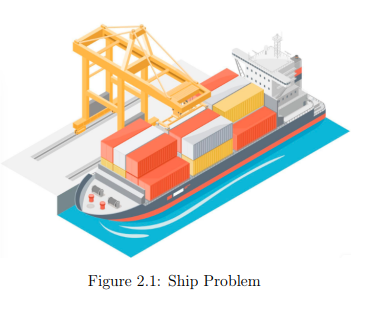

### **SOLUTION**

In [39]:
#Importing necessary libraries
import pandas as pd
from pyomo.environ import *
from google.colab import files
from IPython.display import display

#### **Data**

In [3]:
#If running with Colab notebooks, to upload of data.xlsx file
uploaded = files.upload()

Saving data.xlsx to data.xlsx


In [4]:
xlsx = pd.ExcelFile("data.xlsx")
data = pd.read_excel(xlsx,sheet_name='shipProblem')
data.head()

,Container,Sales Order,Steel Pipe,Steel Pipe weight (kg),Steel Pipe volume (m³),Density (kg/m³)
0,A,SO_1,1,294,140.00,2.100000
1,A,SO_1,2,832,94.87,8.769896
2,B,SO_1,1,977,101.14,9.659877
3,B,SO_1,2,57,8.88,6.418919
4,B,SO_1,3,999,135.55,7.369974


In [41]:
# Transform data frame into a dictionary, get more efficiency when searching for values
ITEMS = dict()
for i in data.index:
  c = data.iloc[i]["Container"]
  if not ITEMS.get(c,False):
    ITEMS[c] = dict()
  s_o = data.iloc[i]["Sales Order"]
  if not ITEMS.get(c,{}).get(s_o,False):
    ITEMS[c][s_o]=dict()
  s_p = data.iloc[i]["Steel Pipe"]
  ITEMS[c][s_o][s_p] = {
      "weight": data.iloc[i]["Steel Pipe weight (kg)"],
      "volume": data.iloc[i]["Steel Pipe volume (m³)"],
      "density": data.iloc[i]["Density (kg/m³)"]
  }

#### **Variables**

This problem has similarity with the *bin packing problem*. There are many variations of this problem, such as linear packing, packing by weight, and packing by cost, for instance. The bin packing problem can also be seen as a special case of the cutting stock problem. When the number of bins is restricted to 1 and each item is characterized by both a volume and a value, the problem of maximizing the value of items that can fit in the bin is known as the *knapsack problem*.

In this problem, the variable X indicates whether an item is selected from a given container ($i$), sales order ($j$) and the specific steel pipe ($k$). The variable Y indicates whether the container $i$ is used in the solution or not.

\begin{align*}
  X_{i,j,k} =
  \begin{cases}
      1, & \text{if item from container } i \text{ sales order j and steel pipe k was choosen } \\
      0, & \text{otherwise}
  \end{cases}
\end{align*}

\begin{align*}
 Y_i =
 \begin{cases}
      1, & \text{if container } i \text{ was used choosen} \\
      0, & \text{otherwise}
 \end{cases}
\end{align*}

#### **Constraints**

In this problem, there are 40 containers that contain steel pipes, but due to the business rules, it is necessary to select 35 containers. The upper bound limit is given by $Q$, the quantity capacity for containers. $I$ represents the number of containers.

\begin{align*}
\quad & \sum_{i \in I}{Y_{i}} = \text{Q,} & \forall ~i \in I
\end{align*}

Also, in this problem each steel pipe has a weight $w_{i,j,k}$, a volume $v_{i,j,k}$ and a density $d_{i,j,k}$, along with a maximum weight capacity $W$ and maximum volume $V$.

\begin{align*}
 \quad & \sum_{i \in I}\sum_{j \in J} \sum_{k \in K}{w_{i,j,k} X_{i,j,k}} \leq W & \forall ~i \in I, \forall ~j \in J, \forall ~k \in K\\
    \quad & \sum_{i \in I}\sum_{j \in J} \sum_{k \in K}{v_{i,j,k} X_{i,j,k}} \leq V & \forall ~i \in I, \forall ~j \in J, \forall ~k \in K\\
\end{align*}

The final constraints are the connection between $Y$ and $X$. For each selected container, it is possible to use any number of sales orders (at least one for each selected container). However, it can select only one steel pipe from each sales order. For this, I separated into three constraints condition.

The first constraint represents the case where container $i$ has been selected
and this container has only one sales order type. Then only, one of the steel pipes can be selected. If the container $i$ is not selected, no steel pipes are selected.

\begin{align*}
 \quad & \sum_{k \in K}X_{i,j,k} = Y_i & \forall i,j,k \in (I,J,K): J \supset j = \{1\}\\
\end{align*}

The second constraint is the case where container $i$ has been selected and this container has different sales order types with one type of steel pipe per order. Then, one or more of the steel pipes can be selected. Again, if the container $i$ is not selected, no steel pipes are selected.

\begin{align*}
 \quad & \sum_{j \in J}\sum_{k \in K}(X_{i,j,k} - Y_i) \le 0 & \forall i,j,k \in (I,J,K): J \supset j > \{1\}\\
\end{align*}

The final constraint represents the case where container $i$ has been selected
and this container has different sales order types with more than one type of steel pipe per order. Then one or more of the steel pipes from this container can be selected.  If the container $i$ is not selected, no steel pipes are selected.

\begin{align*}
 \quad & \sum_{j \in J}\sum_{k \in K}X_{i,j,k} \le Y_i & \forall i,j,k \in (I,J,K): J \supset j \neq \{1\} \land K \supset k > \{1\}\\
\end{align*}


#### **Objective function**

I will maximize the density, in the objective function, once the limit volume $V$ is about three times the limit of weight $W$.
\begin{align*}
    \text{Maximize} \quad & \sum_{i \in I}\sum_{j \in J} \sum_{k \in K}{X_{i,j,k}} & \forall i,j,k \in (I,J,K)\\
\end{align*}

$(I,J,K)$ represents the set of containers, sales orders and steel pipe from data.


#### **Math model**

\begin{align*}
    \text{Maximize} \quad & \sum_{i \in I}\sum_{j \in J} \sum_{k \in K}{X_{i,j,k}} & \forall i,j,k \in (I,J,K)\\
\text{s.t.} & \sum_{i \in I}{Y_{i}} = \text{Q,} & \forall ~i \in I \\
 \quad & \sum_{i \in I}\sum_{j \in J} \sum_{k \in K}{w_{i,j,k} X_{i,j,k}} \leq W & \forall ~i \in I, \forall ~j \in J, \forall ~k \in K\\
    \quad & \sum_{i \in I}\sum_{j \in J} \sum_{k \in K}{v_{i,j,k} X_{i,j,k}} \leq V & \forall ~i \in I, \forall ~j \in J, \forall ~k \in K\\
 \quad & \sum_{k \in K}X_{i,j,k} = Y_i & \forall i,j,k \in (I,J,K): J \supset j = \{1\}\\
 \quad & \sum_{j \in J}\sum_{k \in K}(X_{i,j,k} - Y_i) \le 0 & \forall i,j,k \in (I,J,K): J \supset j > \{1\}\\
 \quad & \sum_{j \in J}\sum_{k \in K}X_{i,j,k} \le Y_i & \forall i,j,k \in (I,J,K): J \supset j \neq \{1\} \land K \supset k > \{1\}\\
  \quad & X_{i,j,k} =\{0,1\}, Y_i = \{0,1\}
\end{align*}

#### **Code**

In [45]:
def max_number_containers(m, LIMIT_Q):
  '''
  This function represents the limit on the number of containers that can be selected
  '''
  temp = sum(m.y[i] for i in m.I)
  if type(temp) is int:    # This will be true if the sum was empty
    return Constraint.Skip
  return temp == LIMIT_Q

def max_volume(m, LIMIT_V):
  '''
  This function represents the limit on the total volume of steel pipes that can be selected
  '''
  temp = sum(ITEMS[i][j][k]['volume']*m.x[i,j,k] for i in m.I for j in m.J for k in m.K if (i,j,k) in m.IJK)
  if type(temp) is int:    # This will be true if the sum was empty
    return Constraint.Skip
  return temp <= LIMIT_V

def max_weight(m, LIMIT_W):
  '''
  This function represents the limit on the total weight of steel pipes that can be selected
  '''
  temp = sum(ITEMS[i][j][k]['weight']*m.x[i,j,k] for i in m.I for j in m.J for k in m.K if (i,j,k) in m.IJK)
  if type(temp) is int:    # This will be true if the sum was empty
    return Constraint.Skip
  return temp <= LIMIT_W

def relation_same_order(m,i,j):
  '''
  This function represents the constraint in the case where container i has been selected
  and this container has only one sales order type. Then only, one of the steel pipes can be selected.
  If the container i is not selected, no steel pipes are selected.
  '''
  temp = sum(m.x[i,j,k] for k in m.K if (i,j,k) in m.IJK if len(ITEMS[i].keys()) == 1 )
  if type(temp) is int:    # This will be true if the sum was empty
    return Constraint.Skip
  return temp == m.y[i]

def relation_diff_orders(m,i):
  '''
  This function represents the constraint in the case where container i has been selected
  and this container has different sales order types with one type of steel pipe per order.
  Then, one or more of the steel pipes can be selected.
  If the container i is not selected, no steel pipes are selected.
  '''
  temp = sum(m.x[i,j,k] - m.y[i] for j in m.J for k in m.K if (i,j,k) in m.IJK if len(ITEMS[i].keys()) > 1 )
  if type(temp) is int:    # This will be true if the sum was empty
    return Constraint.Skip
  return temp <= 0

#Condição para diferentes tipos de pedido de venda com mais de um tipo de cano por pedido
def relation_diff_pipes(m,i):
  '''
  This function represents the constraint in the case where container i has been selected
  and this container has different sales order types with more than one type of steel pipe per order.
  Then one or more of the steel pipes from this container can be selected.
  If the container i is not selected, no steel pipes are selected.
  '''
  temp = sum(m.x[i,j,k] for j in m.J for k in m.K if (i,j,k) in m.IJK if (len(ITEMS[i][j].keys()) > 1  and len(ITEMS[i].keys()) != 1 ))
  if type(temp) is int:    # This will be true if the sum was empty
    return Constraint.Skip
  return temp <= m.y[i]



In [46]:
def choosing_pipes(data, ITEMS):
  '''
  This function creates the model and solves the pipe selection problem.
  The input is a dataframe and dict with the characteristics of containers, sales orders and pipes.
  The output is the model (m) and the result object of the solution (status).
  '''
  #Parameters
  LIMIT_V = 18844 #volume limit
  LIMIT_W = 5163.69 # weight limit
  LIMIT_Q = 35 #container limit

  containers = list(data['Container'].unique())
  orders = list(data['Sales Order'].unique())
  items = list(data['Steel Pipe'].unique())

  # Create model
  m = ConcreteModel()

  IJK = tuple((zip(data['Container'].values,data['Sales Order'].values, data['Steel Pipe'].values)))
  m.IJK = Set(dimen=3,initialize=IJK)
  I = containers
  J = orders
  K = items

  m.I = Set(dimen=1,initialize=I)
  m.J = Set(dimen=1,initialize=J)
  m.K = Set(dimen=1,initialize=K)
  # Variables
  m.x = Var(m.I, m.J, m.K, within=Binary)
  m.y = Var(m.I, within=Binary)

  #Setting the objective function, maximize the density
  m.OBJ = Objective(
      expr = sum(ITEMS[i][j][k]['density']*m.x[i,j,k] for i in m.I for j in m.J for k in m.K if (i,j,k) in m.IJK),
      sense = maximize
  )
  #Setting all the constraints
  m.CONS1 = Constraint(rule = max_number_containers(m,LIMIT_Q))
  m.CONS2 = Constraint(m.I,m.J, rule = relation_same_order)
  m.CONS3 = Constraint(m.I, rule = relation_diff_orders)
  m.CONS4 = Constraint(m.I, rule = relation_diff_pipes)
  m.CONS5 = Constraint(rule = max_volume(m,LIMIT_V))
  m.CONS6 = Constraint(rule = max_weight(m,LIMIT_W))

  ##Call the solver glpk
  status = SolverFactory('glpk',executable='/usr/bin/glpsol').solve(m)

  return status, m


In [47]:
#Call the function schedule_problem to solve the problem
# It takes about 50 seconds to run
status, m = choosing_pipes(data, ITEMS)

#### **Results**

In [52]:
# Selected Steel pipes
cont=list()
orders = list()
steel_pipe = list()
weight = list()
volume = list()
density = list()
for i in m.I:
  for j in m.J:
    for k in m.K:
      if (i,j,k) in m.IJK and value(m.x[i,j,k]) != 0:
          cont.append(i)
          orders.append(j)
          steel_pipe.append(k)
          weight.append(ITEMS[i][j][k]['weight'])
          volume.append(ITEMS[i][j][k]['volume'])
          density.append(ITEMS[i][j][k]['density'])

print("\n============================")
print("Containers quantity = %f" % (len(set(cont))))


Containers quantity = 35.000000


In [55]:
# Print the status of the solved problem
print("Status = %s" % status.solver.termination_condition)
print("There is one optimal solution.")
#Parameters
LIMIT_V = 18844 #volume limit
LIMIT_W = 5163.69 # weight limit
LIMIT_Q = 35 #container limit

print(f'Total Weight = {sum(weight):.2f} of max {LIMIT_W:.2f} kg')
print(f'Total Volume = {sum(volume):.2f} of max {LIMIT_V:.2f} m\N{SUPERSCRIPT THREE}')

# Print the value of the objective
print(f'Objective (maximum total density)= = {value(m.OBJ):.2f} kg/m\N{SUPERSCRIPT THREE}')

Status = optimal
There is one optimal solution
Total Weight = 5160.00 of max 5163.69 kg
Total Volume = 705.91 of max 18844.00 m³
Objective (maximum total density)= = 312.83 kg/m³


In [50]:
print("Selected containers = %s" % (set(cont)))

Container selected = {'X', 'AO', 'AG', 'T', 'M', 'N', 'Z', 'B', 'AM', 'C', 'R', 'AC', 'AP', 'Q', 'S', 'AI', 'AN', 'G', 'AF', 'AJ', 'L', 'U', 'AQ', 'H', 'AL', 'AA', 'O', 'K', 'F', 'D', 'Y', 'I', 'P', 'AK', 'J'}


In [51]:
result = {
    "container": cont,
    "sales_order": orders,
    "steel_pipe": steel_pipe,
    "weight": weight,
    "volume": volume,
    "density": density
}
df = pd.DataFrame(result)
display(df)

,container,sales_order,steel_pipe,weight,volume,density
0,B,SO_2,1,194,24.01,8.079967
1,C,SO_2,1,20,3.19,6.269592
2,D,SO_2,2,156,18.08,8.628319
3,F,SO_1,8,191,24.58,7.770545
4,G,SO_1,1,43,5.09,8.447937
5,H,SO_1,6,5,0.54,9.259259
6,I,SO_1,1,505,50.65,9.970385
7,J,SO_1,3,5,0.71,7.042254
8,K,SO_1,2,165,16.85,9.792285
9,L,SO_1,10,17,1.73,9.826590


### REFERENCE

* Mathematical Optimization: Solving Problems using SCIP and Python https://scipbook.readthedocs.io/en/latest/bpp.html

* Pyomo online documentation. Getting Started with pyomo_simplemodel. https://pyomo-simplemodel.readthedocs.io/en/latest/knapsack.html

* Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 9, Dash Optimization Ltd, 2000.

* GLPK online documentation https://www.gnu.org/software/glpk/#TOCdocumentation